# Artificial Neural Network (ANN) from Scratch

## Project Overview
This notebook implements a **customer churn prediction** model using a neural network built entirely from scratch (no TensorFlow/Keras). We use the [Churn Modelling dataset](https://www.kaggle.com/datasets/shrutimechlearn/churn-modelling) to predict whether a bank customer will leave.

### Dataset
- **Source**: Churn_Modelling.csv
- **Target**: `Exited` (1 = customer churned, 0 = retained)
- **Features**: Demographics, account info, and activity metrics

### Why ANN for Churn Prediction?
Customer churn involves complex, non-linear patterns that simple models struggle to capture. A neural network with hidden layers can learn intermediate representations (feature combinations) to model these interactions.

##  What is an Artificial Neural Network (ANN)?

**Artificial Neural Networks** are supervised learning models inspired by biological neurons. They consist of:
- **Input Layer**: Receives raw features
- **Hidden Layers**: Learns intermediate representations through weighted connections
- **Output Layer**: Produces predictions

### Key Components
1. **Weights & Biases**: Learnable parameters that transform inputs
2. **Activation Functions**: Introduce non-linearity (sigmoid, ReLU, tanh)
3. **Loss Function**: Measures prediction error (MSE, cross-entropy)
4. **Backpropagation**: Algorithm to update weights via gradient descent

### Use Cases
- **Classification**: Spam detection, image recognition, churn prediction
- **Regression**: Price forecasting, demand estimation

**Reference**: [Implementing ANN from Scratch](https://www.analyticsvidhya.com/blog/2021/10/implementing-artificial-neural-networkclassification-in-python-from-scratch/)

##  Installation & Imports

In [1]:
#Importing necessary Libraries
import numpy as np
import pandas as pd

In [2]:
#Loading Dataset
data = pd.read_csv("Churn_Modelling.csv")
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None


###  Exploratory Data Analysis

Let's understand our dataset structure and identify preprocessing needs.

###  Feature Selection & Target Extraction

**Rationale for dropping columns**:
- `RowNumber`: Sequential index (no predictive value)
- `CustomerId`: Unique identifier (no pattern)
- `Surname`: Personal name (irrelevant to churn behavior)

We keep columns 3 onwards (Geography, Gender, Age, Tenure, Balance, etc.) as our feature matrix `X`.

In [3]:
X = data.iloc[:,3:-1].values
print(X)

[[619 'France' 'Female' ... 1 1 101348.88]
 [608 'Spain' 'Female' ... 0 1 112542.58]
 [502 'France' 'Female' ... 1 0 113931.57]
 ...
 [709 'France' 'Female' ... 0 1 42085.58]
 [772 'Germany' 'Male' ... 1 0 92888.52]
 [792 'France' 'Female' ... 1 0 38190.78]]


In [4]:
#Generating Dependent Variable Vectors
Y = data.iloc[:,-1].values

##  Feature Engineering

Transforming categorical and numerical features to make them suitable for neural network training.

###  Encoding Categorical Variable: Gender

**Label Encoding** for binary categorical variable (Male/Female → 0/1).
- Suitable for ordinal or binary features
- Converts text labels to numerical values

In [5]:
from sklearn.preprocessing import LabelEncoder
LE1 = LabelEncoder()
X[:,2] = np.array(LE1.fit_transform(X[:,2]))

###  Encoding Categorical Variable: Geography (Country)

**One-Hot Encoding** for nominal categorical variable with >2 categories.
- Creates binary columns for each country (France, Germany, Spain)
- Prevents the model from assuming ordinal relationships
- Resulting features: 3 country columns + remaining features

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct =ColumnTransformer(transformers=[('encoder',OneHotEncoder(),[1])],remainder="passthrough")
X = np.array(ct.fit_transform(X))

###  Train-Test Split

Splitting data into 80% training and 20% testing to evaluate model generalization.
- **Training set**: Used to learn weights and biases
- **Test set**: Held-out data to measure real-world performance
- Random state = 0 ensures reproducibility

In [7]:
# Splitting dataset into training and testing dataset
from sklearn.model_selection import train_test_split

# First split: 80% train, 20% test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# Second split: Create validation set from training data (10% of total data)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.125, random_state=0)

# Force y to be column vectors (N, 1) instead of (N,)
Y_train = Y_train.reshape(-1, 1)
Y_val = Y_val.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 7000 samples
Validation set: 1000 samples
Test set: 2000 samples


###  Feature Scaling (Standardization)

**Why scale features?**
- Neural networks are sensitive to feature magnitude
- Features like `Balance` (0-250K) vs `Age` (18-92) have different ranges
- **Standardization**: Transforms features to mean=0, std=1
  
$$X_{scaled} = \frac{X - \mu}{\sigma}$$

**Important**: Use `fit_transform` on training data, but only `transform` on test data to avoid data leakage.

In [8]:
# Performing Feature Scaling (Standardization)
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)  # Use same scaling parameters as training
X_test = sc.transform(X_test)

##  Model Training & Evaluation

##  Neural Network Architecture (From Scratch)

### Network Design
```
Input Layer (12 features) → Hidden Layer (6 neurons) → Output Layer (1 neuron)
```

### Key Implementation Details

#### 1️ **THe Weight Initialization**
Prevents vanishing/exploding gradients:
$$W \sim \mathcal{N}\left(0, \sqrt{\frac{2}{n_{in}}}\right)$$

#### 2️ **Activation Function: Sigmoid**
$$\sigma(z) = \frac{1}{1 + e^{-z}}$$
- Output range: (0, 1) → suitable for binary classification
- Derivative: $\sigma'(z) = \sigma(z) \cdot (1 - \sigma(z))$

#### 3️ **Forward Propagation**
1. Hidden layer: $a_1 = \sigma(X \cdot W_1 + b_1)$
2. Output layer: $a_2 = \sigma(a_1 \cdot W_2 + b_2)$

#### 4️ **Backpropagation**
Compute gradients using chain rule and update weights:
- $\frac{\partial L}{\partial W_2}$, $\frac{\partial L}{\partial b_2}$ (output layer)
- $\frac{\partial L}{\partial W_1}$, $\frac{\partial L}{\partial b_1}$ (hidden layer)

#### 5️ **Loss Function: Mean Squared Error**
$$L = \frac{1}{m}\sum_{i=1}^{m}(y_i - \hat{y}_i)^2$$

In [9]:
class ChurnANN:
    def __init__(self, input_size, hidden_size, learning_rate=0.01):
        # Weight Initialization (He Initialization)
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2/input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, 1) * np.sqrt(2/hidden_size)
        self.b2 = np.zeros((1, 1))
        self.lr = learning_rate

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, a):
        return a * (1 - a)

    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.sigmoid(self.z2)
        return self.a2

    def backward(self, X, y, output):
        m = y.shape[0]
        
        # Error at Output Layer
        dz2 = output - y
        dW2 = np.dot(self.a1.T, dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m
        
        # Error at Hidden Layer (Backpropagated)
        dz1 = np.dot(dz2, self.W2.T) * self.sigmoid_derivative(self.a1)
        dW1 = np.dot(X.T, dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m
        
        # Update Weights
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2

    def train(self, X, y, epochs=1000):
        for i in range(epochs):
            output = self.forward(X)
            self.backward(X, y, output)
            if i % 100 == 0:
                loss = np.mean(np.square(y - output))
                print(f"Epoch {i}, Loss: {loss:.4f}")



In [10]:
# Initialize and Train
input_dim = X_train.shape[1]  # Usually 12 columns
model = ChurnANN(input_size=input_dim, hidden_size=6, learning_rate=0.1)
model.train(X_train, Y_train, epochs=2000)



Epoch 0, Loss: 0.2169
Epoch 100, Loss: 0.1502
Epoch 200, Loss: 0.1449
Epoch 300, Loss: 0.1409
Epoch 400, Loss: 0.1380
Epoch 500, Loss: 0.1359
Epoch 600, Loss: 0.1345
Epoch 700, Loss: 0.1335
Epoch 800, Loss: 0.1328
Epoch 900, Loss: 0.1323
Epoch 1000, Loss: 0.1319
Epoch 1100, Loss: 0.1315
Epoch 1200, Loss: 0.1312
Epoch 1300, Loss: 0.1309
Epoch 1400, Loss: 0.1306
Epoch 1500, Loss: 0.1304
Epoch 1600, Loss: 0.1301
Epoch 1700, Loss: 0.1299
Epoch 1800, Loss: 0.1296
Epoch 1900, Loss: 0.1294


In [11]:
# Make Predictions on Test Set
Y_pred_prob = model.forward(X_test)
predictions = (Y_pred_prob > 0.5).astype(int)

# Evaluate on Test Set
accuracy = np.mean(predictions == Y_test)

# Calculate additional metrics
tp = np.sum((predictions == 1) & (Y_test == 1))
tn = np.sum((predictions == 0) & (Y_test == 0))
fp = np.sum((predictions == 1) & (Y_test == 0))
fn = np.sum((predictions == 0) & (Y_test == 1))

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("\n" + "=" * 50)
print("TEST SET EVALUATION METRICS")
print("=" * 50)
print(f"Accuracy:  {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print("=" * 50)


TEST SET EVALUATION METRICS
Accuracy:  82.55%
Precision: 0.6707
Recall:    0.2716
F1-Score:  0.3866


## Visualizing Results

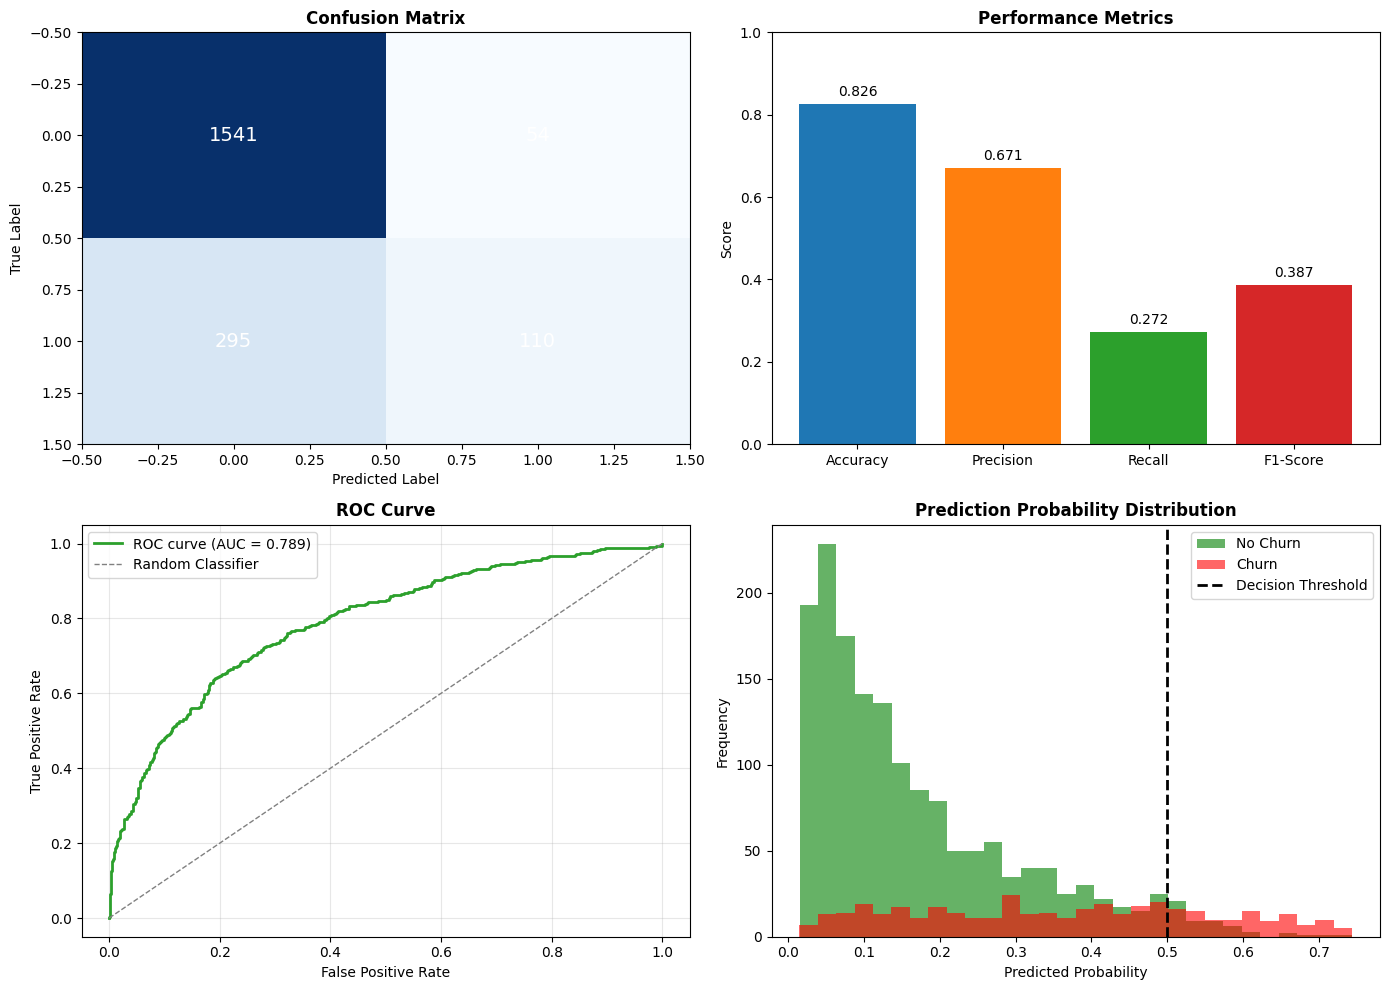

In [12]:

# Visualization
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Confusion Matrix
cm = confusion_matrix(Y_test, predictions)
axes[0, 0].imshow(cm, cmap='Blues', aspect='auto')
axes[0, 0].set_title('Confusion Matrix', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('True Label')
axes[0, 0].set_xlabel('Predicted Label')
for i in range(2):
    for j in range(2):
        axes[0, 0].text(j, i, str(cm[i, j]), ha='center', va='center', color='white', fontsize=14)

# 2. Metrics Bar Chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]
axes[0, 1].bar(metrics, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[0, 1].set_title('Performance Metrics', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_ylim([0, 1])
for i, v in enumerate(values):
    axes[0, 1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=10)

# 3. ROC Curve
fpr, tpr, _ = roc_curve(Y_test, Y_pred_prob)
roc_auc = auc(fpr, tpr)
axes[1, 0].plot(fpr, tpr, color='#2ca02c', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[1, 0].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Classifier')
axes[1, 0].set_title('ROC Curve', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# 4. Prediction Distribution
axes[1, 1].hist(Y_pred_prob[Y_test == 0], bins=30, alpha=0.6, label='No Churn', color='green')
axes[1, 1].hist(Y_pred_prob[Y_test == 1], bins=30, alpha=0.6, label='Churn', color='red')
axes[1, 1].axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
axes[1, 1].set_title('Prediction Probability Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Predicted Probability')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend(fontsize=10)

plt.tight_layout()
plt.show()